## Project 4: West Nile Virus Prediction
------------------------------------------------------------------------------------------------------------------------
## Part 2. Preprocessing & Modelling
Group 2 (Edmund, Marc, Mingzi, Rohazeanti), SG DSIF5 

## Table of Contents
- [Importing the libraries](#Importing-the-libraries)
- [Importing the datasets](#Importing-the-datasets)
- [Merge weather dataset to train and test dataset](#Merge-weather-dataset-to-train-and-test-dataset)
- [Feature Selection and Engineering](#Feature-Selection-and-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modelling](#Modelling)
- [Model evaluation and recommendations](#Model-evaluation-and-recommendations)
- [Visualising ROC Curve for the models](#Visualising-ROC-Curve-for-the-models)
- [Kaggle Submission](#Kaggle-Submission)

### Importing the libraries

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import calmap
import scipy.stats as stats
import pickle

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, RocCurveDisplay, plot_roc_curve, roc_auc_score, recall_score, precision_score

import datetime
from suntime import Sun, SunTimeException
from pytz import timezone
import pytz

%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing the datasets

In [7]:
# Import train dataset from pickle file
train = pd.read_pickle('./data/train_final.pkl')
print(f'The training data has {train.shape[0]} rows and {train.shape[1]} columns')

# Import test dataset from pickle file
test = pd.read_pickle('./data/test_final.pkl')
print(f'The test data has {test.shape[0]} rows and {test.shape[1]} columns')

# Import weather dataset from pickle file
weather = pd.read_pickle('./data/weather_final.pkl')
print(f'The weather data has {weather.shape[0]} rows and {weather.shape[1]} columns')

The training data has 8610 rows and 12 columns
The test data has 116293 rows and 11 columns
The weather data has 2918 rows and 23 columns


In [8]:
train.head()

,Date,Species,Trap,Latitude,Longitude,WnvPresent,NumMosquitos,Year,Month,Day,Week,Station
0,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0,1,2007,5,29,22,2.0
1,2007-05-29,CULEX RESTUANS,T048,41.867108,-87.654224,0,2,2007,5,29,22,2.0
2,2007-05-29,CULEX RESTUANS,T091,41.862292,-87.648860,0,1,2007,5,29,22,2.0
3,2007-05-29,CULEX RESTUANS,T049,41.896282,-87.655232,0,1,2007,5,29,22,2.0
4,2007-05-29,CULEX RESTUANS,T153,41.907645,-87.760886,0,1,2007,5,29,22,2.0


In [9]:
test.head()

,Id,Date,Species,Trap,Latitude,Longitude,Year,Month,Day,Week,Station
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2008,6,11,24,1.0
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991,2008,6,11,24,1.0
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991,2008,6,11,24,1.0
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991,2008,6,11,24,1.0
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991,2008,6,11,24,1.0


In [10]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,WetDry,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,Day,Week,SunHours,R_Humid,Trange
0,1,2007-05-01,83,50,67,51,56,0,2,0,0.0,29.10,29.82,1.7,27,9.2,2007,5,1,18,14.016667,56.438576,33
1,2,2007-05-01,84,52,68,51,57,0,3,0,0.0,29.18,29.82,2.7,25,9.6,2007,5,1,18,14.016667,54.526426,32
2,1,2007-05-02,59,42,51,42,47,14,0,1,0.0,29.38,30.09,13.0,4,13.4,2007,5,2,18,14.050000,71.195808,17
3,2,2007-05-02,60,43,52,42,47,13,0,1,0.0,29.44,30.08,13.3,2,13.4,2007,5,2,18,14.050000,68.614962,17
4,1,2007-05-03,66,46,56,40,48,9,0,0,0.0,29.39,30.12,11.7,7,11.9,2007,5,3,18,14.083333,54.874919,20


In [11]:
# Drop Year, Month, Day, Week columns from weather dataset
weather.drop(['Year', 'Month', 'Day', 'Week'], axis=1, inplace=True)

### Merge weather dataset to train and test dataset


In [12]:
# Merge Training and Weather dataset
train_weather = pd.merge(train, weather, on=['Date','Station'])
print(f'The training data has {train_weather.shape[0]} rows and {train_weather.shape[1]} columns')

# Merge Test and Weather dataset
test_weather = pd.merge(test, weather, on=['Date','Station'])
print(f'The test data has {test_weather.shape[0]} rows and {test_weather.shape[1]} columns')


The training data has 8554 rows and 29 columns
The test data has 116293 rows and 28 columns


In [13]:
train_weather.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'WnvPresent',
       'NumMosquitos', 'Year', 'Month', 'Day', 'Week', 'Station', 'Tmax',
       'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'WetDry',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'SunHours', 'R_Humid', 'Trange'],
      dtype='object')

In [14]:
test_weather.columns

Index(['Id', 'Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'Year',
       'Month', 'Day', 'Week', 'Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'WetDry', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'SunHours',
       'R_Humid', 'Trange'],
      dtype='object')

### Feature Selection and Engineering

The following feature engineering and selection will be conducted
1) Drop unnecessary columns
2) Correlation heatmap of dataset features
3) Variance Inflation factor of features
4) Creation of Time lag features
4) Creation of dummy variables for categorical features
    - Species
    - Traps
5) Standardize common features of Train and test for Model training

In [15]:
# The following columns will be dropped from the dataset
to_drop = ['Date','Station','Year','Day']
train_weather.drop(to_drop, axis=1, inplace=True)
test_weather.drop(to_drop, axis=1, inplace=True)

#### Correlation heatmap of dataset features

<AxesSubplot:>

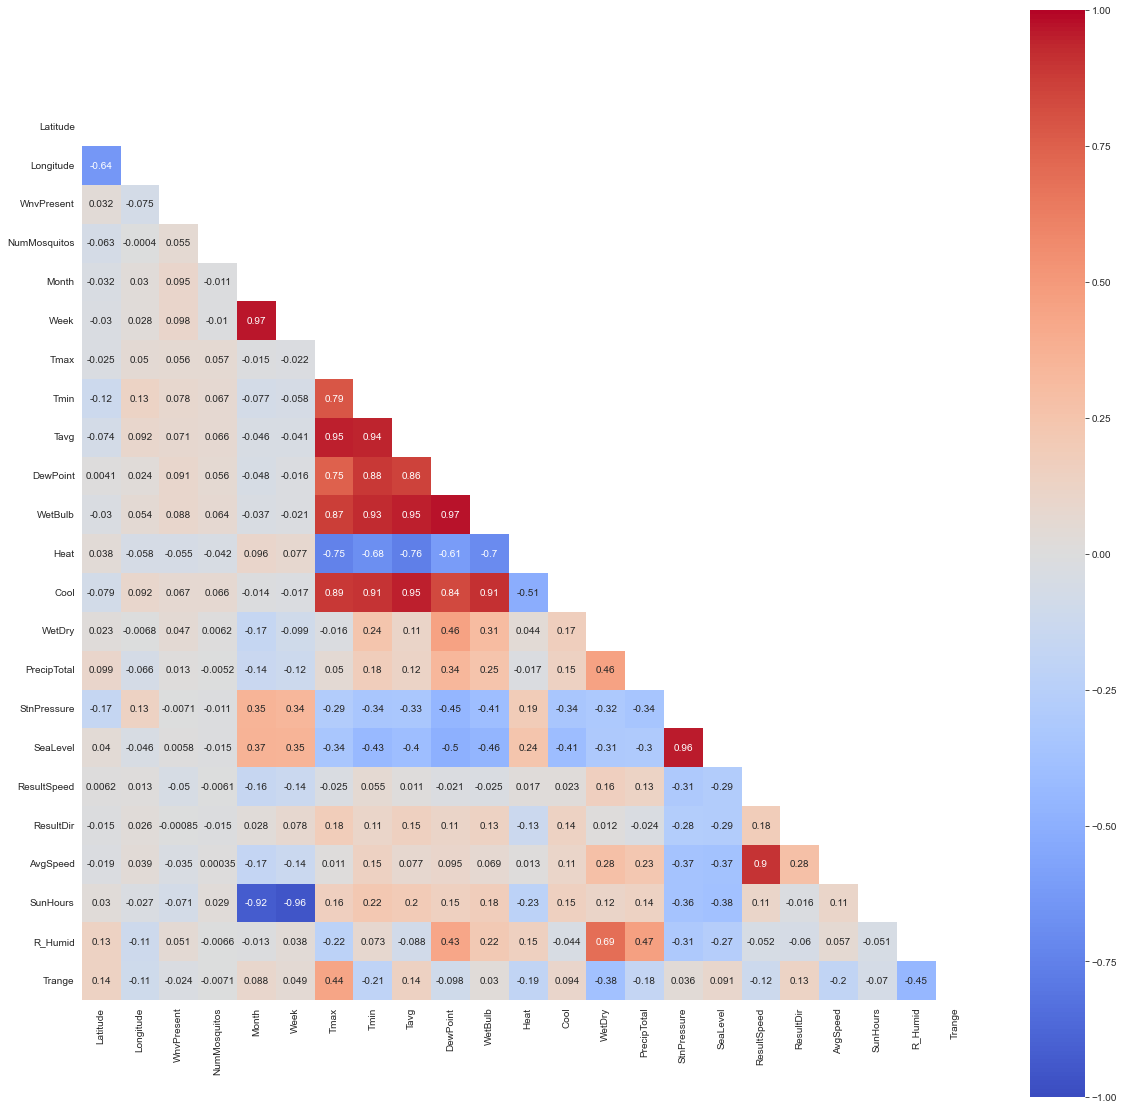

In [16]:
corr = train_weather.corr()

fig, ax = plt.subplots(figsize=(20,20))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
sns.heatmap(data= corr,       
            mask= mask,
            cmap = 'coolwarm',
            square= True,          
            annot = True,
            vmin=-1, vmax=1)

From the heatmap, we can see that there are some features that are highly correlated (>0.90) with each other. The features are as follows:
- Tavg and Tmax | Tavg and Tmin
- WetBulb and Tmin | WetBulb and Tavg | WetBulb and DewPoint
- Cool and Tmin | Cool and Tavg | Cool and WetBulb
- SeaLevel and StnPressure
- AvgSpeed and ResultSpeed

We will compute the VIF of these features 

In [17]:
considered_features = ['Tavg','Tmin','Tmax','WetBulb','DewPoint','Cool','SeaLevel','StnPressure','AvgSpeed','ResultSpeed']

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(considered_features):

    X = train_weather[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1

    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Features']!='intercept']
    return vif

In [19]:
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\Mingzi\AppData\Local\Temp/ipykernel_9200/3110509376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Features,VIF
0,Tavg,973.391747
2,Tmax,305.190035
1,Tmin,256.935953
3,WetBulb,182.483013
4,DewPoint,77.915091
6,SeaLevel,14.790723
7,StnPressure,14.563794
5,Cool,10.535633
8,AvgSpeed,6.294062
9,ResultSpeed,6.087776


We will remove the feature with the highest VIF value and check the VIF values again. We will repeat this process until all the VIF values are less than 10.

In [20]:
considered_features.remove('Tavg')
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\Mingzi\AppData\Local\Temp/ipykernel_9200/3110509376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Features,VIF
2,WetBulb,181.639992
3,DewPoint,77.282173
1,Tmax,19.291544
5,SeaLevel,14.709148
6,StnPressure,14.492022
0,Tmin,14.375170
4,Cool,10.425622
7,AvgSpeed,6.275977
8,ResultSpeed,6.039438


In [21]:
considered_features.remove('WetBulb')
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\Mingzi\AppData\Local\Temp/ipykernel_9200/3110509376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Features,VIF
4,SeaLevel,14.646020
5,StnPressure,14.382465
3,Cool,10.417395
0,Tmin,9.402695
6,AvgSpeed,6.184987
2,DewPoint,6.183684
7,ResultSpeed,6.028309
1,Tmax,5.179198


In [22]:
considered_features.remove('SeaLevel')
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\Mingzi\AppData\Local\Temp/ipykernel_9200/3110509376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Features,VIF
3,Cool,10.417226
0,Tmin,8.543127
5,AvgSpeed,6.018726
2,DewPoint,5.938927
6,ResultSpeed,5.844719
1,Tmax,5.168275
4,StnPressure,1.533832


In [23]:
considered_features.remove('Cool')
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\Mingzi\AppData\Local\Temp/ipykernel_9200/3110509376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Features,VIF
0,Tmin,5.938951
2,DewPoint,5.934488
4,AvgSpeed,5.901383
5,ResultSpeed,5.755433
1,Tmax,2.839641
3,StnPressure,1.531807


In [24]:
# Collate the features that are to be dropped
drop_features = ['Tavg','WetBulb','SeaLevel','Cool']

In [25]:
# Drop the features from the training and test dataset
train_weather.drop(drop_features, axis=1, inplace=True)
test_weather.drop(drop_features, axis=1, inplace=True)

#### Creation of Time lag features

It takes about 7-10 days for an egg to develop into an adult mosquito. 
(https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html. 

Therefore, new columns will be created with the various weather columns being offset by 7 days. This will allow the model to learn from the weather conditions 1 weeks prior to the presence of the virus.

In [26]:
train_weather.columns

Index(['Species', 'Trap', 'Latitude', 'Longitude', 'WnvPresent',
       'NumMosquitos', 'Month', 'Week', 'Tmax', 'Tmin', 'DewPoint', 'Heat',
       'WetDry', 'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'SunHours', 'R_Humid', 'Trange'],
      dtype='object')

In [27]:
# Create a dataframe for Time lag features
lag_features = ['Tmax','Tmin','DewPoint','Heat', 'WetDry','PrecipTotal','StnPressure','ResultSpeed','ResultDir','AvgSpeed','SunHours','Trange','R_Humid']

suffix = '_7d'
shift = 7

for feat in lag_features:
    # Create shifted columns for lagged features for both train and test
    train_weather[feat+suffix] = train_weather[feat].shift(shift)
    test_weather[feat+suffix] = test_weather[feat].shift(shift)
    # Fill in original values for first 14 days
    train_weather[feat+suffix].fillna(train_weather[feat], inplace = True)
    test_weather[feat+suffix].fillna(test_weather[feat], inplace = True)

#### Creation of dummy variables for categorical features

In [28]:
train_weather['Species'].value_counts()

CULEX PIPIENS/RESTUANS    3878
CULEX RESTUANS            2383
CULEX PIPIENS             1989
CULEX TERRITANS            215
CULEX SALINARIUS            82
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [29]:
# As we know previously, the mosquitos that will spread WNV are of the species CULEX PIPIENS and CULEX RESTUANS. We will map the rest of the species to 'OTHERS'
wnv_species = ['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']
train_weather['Species'] = train_weather['Species'].apply(lambda x: x if x in wnv_species else 'OTHERS')
test_weather['Species'] = test_weather['Species'].apply(lambda x: x if x in wnv_species else 'OTHERS')

Get dummies for Species and Traps

In [30]:
train_weather = pd.get_dummies(train_weather, columns = ['Species','Trap','Month','Week'], drop_first = True)
test_weather = pd.get_dummies(test_weather, columns = ['Species','Trap','Month','Week'], drop_first = True)

In [31]:
print(train_weather.shape)
print(test_weather.shape)

(8554, 192)
(116293, 202)


#### Standardize common features of Train and test for Model training

In [32]:
# List all the features in the training and test DataFrames

train_features = [x for x in train_weather.columns if x != "WnvPresent"]   # Lists all feature names excluding the target
test_features = [x for x in test_weather.columns]   # Lists all features

In [33]:
# Select the common features between the 2 datasets (i.e only found in training and test datasets)

common_features = [x for x in train_features if x in test_features]

In [34]:
# Number of common features

print(f"The training set has {len(train_features)} features, while the test dataset has {len(test_features)} features.")
print(f"There are {len(common_features)} common features between the 2 datasets")

The training set has 191 features, while the test dataset has 202 features.
There are 188 common features between the 2 datasets


In [35]:
# List of common_features
common_features

['Latitude',
 'Longitude',
 'Tmax',
 'Tmin',
 'DewPoint',
 'Heat',
 'WetDry',
 'PrecipTotal',
 'StnPressure',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'SunHours',
 'R_Humid',
 'Trange',
 'Tmax_7d',
 'Tmin_7d',
 'DewPoint_7d',
 'Heat_7d',
 'WetDry_7d',
 'PrecipTotal_7d',
 'StnPressure_7d',
 'ResultSpeed_7d',
 'ResultDir_7d',
 'AvgSpeed_7d',
 'SunHours_7d',
 'Trange_7d',
 'R_Humid_7d',
 'Species_CULEX PIPIENS/RESTUANS',
 'Species_CULEX RESTUANS',
 'Species_OTHERS',
 'Trap_T002',
 'Trap_T003',
 'Trap_T004',
 'Trap_T005',
 'Trap_T006',
 'Trap_T007',
 'Trap_T008',
 'Trap_T009',
 'Trap_T011',
 'Trap_T012',
 'Trap_T013',
 'Trap_T014',
 'Trap_T015',
 'Trap_T016',
 'Trap_T017',
 'Trap_T018',
 'Trap_T019',
 'Trap_T025',
 'Trap_T027',
 'Trap_T028',
 'Trap_T030',
 'Trap_T031',
 'Trap_T033',
 'Trap_T034',
 'Trap_T035',
 'Trap_T036',
 'Trap_T037',
 'Trap_T039',
 'Trap_T040',
 'Trap_T043',
 'Trap_T044',
 'Trap_T045',
 'Trap_T046',
 'Trap_T047',
 'Trap_T048',
 'Trap_T049',
 'Trap_T050',
 'Trap_T051

#### Perform Train/test split of data

In [36]:
# Using the common feature list, select the common features from the training and test datasets

X_kag_train = train_weather[common_features]
X_kag_test = test_weather[common_features]

# Target variable
y_kag_train = train_weather['WnvPresent']

In [37]:
X_kag_train.shape, y_kag_train.shape

((8554, 188), (8554,))

In [38]:
# define categorical and numerical features
categorical_features = X_kag_train.select_dtypes(include = ['object']).columns
numerical_features = X_kag_train.select_dtypes(include = ['float64', 'int64']).columns

In [39]:
categorical_features

Index([], dtype='object')

In [40]:
numerical_features

Index(['Latitude', 'Longitude', 'Tmax', 'Tmin', 'DewPoint', 'WetDry',
       'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'SunHours', 'R_Humid', 'Trange', 'Tmax_7d', 'Tmin_7d', 'DewPoint_7d',
       'Heat_7d', 'WetDry_7d', 'PrecipTotal_7d', 'StnPressure_7d',
       'ResultSpeed_7d', 'ResultDir_7d', 'AvgSpeed_7d', 'SunHours_7d',
       'Trange_7d', 'R_Humid_7d'],
      dtype='object')

In [41]:
# Perform train, test, split

X_train, X_test, y_train, y_test = train_test_split(X_kag_train, 
                                                    y_kag_train,
                                                    random_state=42,
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y_kag_train)

In [42]:
# Check the shape of our dataframe
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of y_test is {y_test.shape}")

The shape of X_train is (5987, 188)
The shape of X_test is (2567, 188)
The shape of y_train is (5987,)
The shape of y_test is (2567,)


<!-- #### Utilise Variance Inflation Factor to reduce features collinearity -->

#### Min Max Scaling of Numerical Features

In [43]:
# define categorical and numerical features
categorical_features = X_train.select_dtypes(include = ['object']).columns
numerical_features = X_train.select_dtypes(include = ['float64', 'int64']).columns

In [44]:
#instantiate MinMaxScaler()
scaler = MinMaxScaler()

#fit train set
scaler.fit(X_train[numerical_features])

scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

#transform X_train and X_test set
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [45]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,5987.0,0.535024,0.286528,0.0,0.284015,0.540937,0.805372,1.0
Longitude,5987.0,0.589609,0.213349,0.0,0.447175,0.587755,0.721181,1.0
Tmax,5987.0,0.612164,0.209484,0.0,0.525000,0.650000,0.750000,1.0
Tmin,5987.0,0.594732,0.202071,0.0,0.473684,0.631579,0.763158,1.0
DewPoint,5987.0,0.609578,0.227318,0.0,0.457143,0.600000,0.828571,1.0
...,...,...,...,...,...,...,...,...
Week_36,5987.0,0.041757,0.200050,0.0,0.000000,0.000000,0.000000,1.0
Week_37,5987.0,0.054117,0.226268,0.0,0.000000,0.000000,0.000000,1.0
Week_38,5987.0,0.069985,0.255143,0.0,0.000000,0.000000,0.000000,1.0
Week_39,5987.0,0.052113,0.222273,0.0,0.000000,0.000000,0.000000,1.0


### Modelling

The following models were used to predict the presence of WNV in the test dataset:
1)  Logistic Regression w/o SMOTE (Baseline Model)
2) Logistic Regression w SMOTE
3) Random Forest Classifier w/ SMOTE
4) Multinomial Naive Bayes w SMOTE
5) k-Nearest Neighbors w SMOTE
6) AdaBoost Classifier w SMOTE
7) Gradient Boosting Classifier w SMOTE
8) XGBoost Classifier w SMOTE

#### Establish baseline accuracy of "No model" for comparison to models

The baseline accuracy is about 5.24% for WNV positive cases as majority class of WNV negative cases comprise 94.7% of the data. 

In [46]:
# Calculating the percentage of WNV-positive vs. WNV-negative cases in our kaggle_training dataset

train_weather["WnvPresent"].value_counts(normalize=True)

0    0.946575
1    0.053425
Name: WnvPresent, dtype: float64

As data is imbalanced with only 5% of WNV positive cases.
SMOTE will also be used to address the data imbalance by oversampling the minority class

In [47]:
# Applying SMOTE to our datasets
smt = SMOTE(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

In [48]:
X_train

,Latitude,Longitude,Tmax,Tmin,DewPoint,Heat,WetDry,PrecipTotal,StnPressure,ResultSpeed,ResultDir,AvgSpeed,SunHours,R_Humid,Trange,Tmax_7d,Tmin_7d,DewPoint_7d,Heat_7d,WetDry_7d,PrecipTotal_7d,StnPressure_7d,ResultSpeed_7d,ResultDir_7d,AvgSpeed_7d,SunHours_7d,Trange_7d,R_Humid_7d,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_OTHERS,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Month_7,Month_8,Month_9,Month_10,Week_23,Week_24,Week_25,Week_26,Week_27,Week_28,Week_29,Week_30,Week_31,Week_32,Week_33,Week_34,Week_35,Week_36,Week_37,Week_38,Week_39,Week_40
7409,0.771105,0.578120,0.625,0.526316,0.457143,0,0.0,0.000000,0.526316,0.398693,0.800000,0.352113,0.783550,0.243849,0.533333,0.625,0.526316,0.457143,0.000000,0.0,0.000000,0.526316,0.398693,0.800000,0.352113,0.783550,0.533333,0.243849,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
821,0.284015,0.815557,0.850,0.736842,0.714286,0,0.0,0.000000,0.592105,0.130719,0.342857,0.112676,0.783550,0.312710,0.566667,0.850,0.736842,0.714286,0.000000,0.0,0.000000,0.592105,0.130719,0.342857,0.112676,0.783550,0.566667,0.312710,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
237,0.939812,0.404938,0.550,0.315789,0.342857,0,0.0,0.000000,0.789474,0.379085,0.371429,0.422535,0.987013,0.315044,0.700000,0.550,0.315789,0.342857,0.000000,0.0,0.000000,0.789474,0.379085,0.371429,0.422535,0.987013,0.700000,0.315044,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8271,0.771105,0.578120,0.650,0.578947,0.571429,0,0.0,0.015113,0.592105,0.437908,0.942857,0.542254,0.324675,0.383586,0.500000,0.650,0.578947,0.571429,0.000000,0.0,0.015113,0.592105,0.437908,0.942857,0.542254,0.324675,0.500000,0.383586,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [49]:
# Check proportions after SMOTE
y_train_smt.value_counts()

1    5667
0    5667
Name: WnvPresent, dtype: int64

The over-sampled data will only be used when evaluating the train and test scores. When we are applying GridSearchCV to tune the hyperparameters, we will need to utilize an imblearn.Pipeline object to handle the samplers correctly.

#### Define function for modelling and evaluation

In [50]:
# Set up Pipelines for the different models

# Logistic Regression Pipeline w SMOTE
pipe_lr = Pipeline([
    ('lr', LogisticRegression())
])
# Random Forest Pipeline w SMOTE
pipe_rf = Pipeline([
    ('rf', RandomForestClassifier())
])

# Decision Tree w SMOTE
pipe_dt = Pipeline([
    ('dt', DecisionTreeClassifier())
])

# Multinomial Naive Bayes Pipeline w SMOTE
pipe_mnb = Pipeline([
    ('mnb', MultinomialNB())
])

# k-Nearest Neighbors w SMOTE
pipe_knn = Pipeline([
    ('knn', KNeighborsClassifier())
])

# AdaBoost w SMOTE
pipe_ada = Pipeline([
    ('ada', AdaBoostClassifier())
])

# XGBoost w SMOTE
pipe_xgb = Pipeline([
    ('xgb',xgb.XGBClassifier())
])  

# Gradient Boosting w SMOTE
pipe_gb = Pipeline([
    ('gb',GradientBoostingClassifier())
])

In [51]:
# Set up Parameters for the different models

params_lr = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear'],   
    'lr__class_weight': ['balanced']
}

params_rf = {
    "rf__n_estimators": [25, 50, 100, 150, 200],
    'rf__max_features': ['auto', 'log2'],
    "rf__max_depth": [20, 50, 80, 100, 200],
    "rf__min_samples_leaf": [2, 3, 4],
    'rf__min_samples_split': [3, 5, 7],
    'rf__bootstrap': [True, False]
}

params_dt = {
    'dt__criterion' : ['gini', 'entropy'],
    'dt__max_depth' : [3, 5, 10, 20, 50, 100],
    'dt__min_samples_split' : [3, 5, 7],
    'dt__min_samples_leaf' : [1, 2, 3]
}
                
params_mnb = {
    'mnb__alpha': [1, .9, .8]
}


params_knn = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

params_ada = {
    "ada__learning_rate": [0.5, 1],
    "ada__n_estimators": [200, 500, 600, 700],
}

params_xgb = {
    'xgb__max_depth': [3, 4, 5, 10],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__learning_rate': [0.1, 0.01, 0.05],
    'xgb__gamma': [0,0.1,0.2,0.4,0.8,1.6]
}

params_gb ={
    'gb__n_estimators': [10, 50, 100, 250],
    'gb__max_depth':[1, 3, 5, 7],
    'gb__learning_rate': [0.01, 0.1, 1],
    'gb__min_samples_split' : [3, 5, 7],
    'gb__min_samples_leaf' : [1, 2, 3],
    'gb__max_features': ['auto', 'sqrt', 'log2']
}

In [52]:
#Create a dictionary to house the different models score
results = {}

In [53]:
#Initialise Confusion Matrix visualisation
def create_cm(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test,y_pred)
    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['WNV Negative', 'WNV Positive'])
    disp.plot(cmap='Blues')
    disp.ax_.set_title(model_name)
    plt.show()

In [54]:
# Define function to run GridSearchCV for each model
def run_model_gs(pipeline, parameters, cv = 3, model_name = '', prefix = ''):
    gs = GridSearchCV(pipeline, parameters, cv = cv, n_jobs = -1, verbose = 1)

    gs.fit(X_train_smt, y_train_smt)

    # Print the best score found on training data
    print('Best Score:', gs.best_score_)
    # Print the best parameters found on training data
    print('Best Parameters:', gs.best_params_)
    # Use the best estimator that gave the highest score
    gs = gs.best_estimator_

    #Score model on Training data
    train_score = round(gs.score(X_train_smt, y_train_smt),3)
    print('Score on Training Data:', train_score)
    # Score model on Testing data
    test_score = round(gs.score(X_test, y_test),3)
    print('Score on Testing Data:', test_score)
    # Generalisation Score
    generalisation = round((train_score - test_score)*100/train_score,3)
    print('Generalisation Score:', generalisation)
    # Get predictions
    y_pred = gs.predict(X_test)

    # Calculate ROC_AUC score
    y_proba = gs.predict_proba(X_test)
    auc = round(roc_auc_score(y_test, y_proba[:,1]),4)

    # Confusion Matrix
    create_cm(y_test, y_pred, model_name)

    # Save performance metrics value
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Print the different metrics
    # Append metrics and scores to the dictionary
    accuracy = round(accuracy_score(y_test, y_pred),3) # Accuracy 
    print('Accuracy:', accuracy)
    precision = round(tp / (tp + fp),3) # Precision (Positive Predictive Value)
    print('Precision:', precision)
    recall = round(tp / (tp + fn),3) # Recall (Sensitivity, True Positive Rate)
    print('Recall:', recall)
    specificity = round(tn / (tn + fp),3) # Specificity (True Negative Rate)
    f1 = round(2 * (precision * recall) / (precision + recall),3) #F1
    print('F1:', f1)
    print('ROC AUC:', auc)


    results[model_name] = [train_score, test_score, generalisation, accuracy, precision, recall, specificity, f1, auc]

    # pickle the model
    gs_file = './models/gs_'+prefix+'.sav'
    pickle.dump(gs, open(gs_file, 'wb'))

In [55]:
def run_model(model, model_name = '', prefix = ''):

    # Fit model
    model.fit(X_train, y_train)

    # Cross validation score of Result
    result = cross_val_score(model, X_train, y_train, cv=5, n_jobs = -1)
    print(f"The cross_val training scores are {result}")
    print(f"Cross Validation Score: {round(result.mean(),3)}")

    #Score model on Training data
    train_score = round(model.score(X_train, y_train),3)
    print('Score on Training Data: ', train_score)
    # Score model on Testing data
    test_score = round(model.score(X_test, y_test),3)
    print('Score on Testing Data: ', test_score)
    #Generalisation Score
    generalisation = round((train_score - test_score)*100/train_score,3)
    print('Generalisation Score: ', generalisation)
    
    # Get prediction
    y_pred = model.predict(X_test)

    # Calculate ROC_AUC score
    y_proba = model.predict_proba(X_test)
    auc = round(roc_auc_score(y_test, y_proba[:,1]),4)

    # Confusion Matrix
    create_cm(y_test, y_pred, model_name)

    # Save performance metrics value
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Print the different metrics
    # Append metrics and scores to the dictionary
    accuracy = round(accuracy_score(y_test, y_pred),3) # Accuracy 
    print('Accuracy:', accuracy)
    precision = round(tp / (tp + fp),3) # Precision (Positive Predictive Value)
    print('Precision:', precision)
    recall = round(tp / (tp + fn),3) # Recall (Sensitivity, True Positive Rate)
    print('Recall:', recall)
    specificity = round(tn / (tn + fp),3) # Specificity (True Negative Rate)
    f1 = round(2 * (precision * recall) / (precision + recall),3) #F1
    print('F1:', f1)
    print('ROC AUC:', auc)

    results[model_name] = [train_score, test_score, generalisation, accuracy, precision, recall, specificity, f1, auc]

#### 1) Model testing - Logistic Regression (w/o SMOTE)

The cross_val training scores are [0.94657763 0.94323873 0.94486216 0.94235589 0.946533  ]
Cross Validation Score: 0.945
Score on Training Data:  0.946
Score on Testing Data:  0.947
Generalisation Score:  -0.106


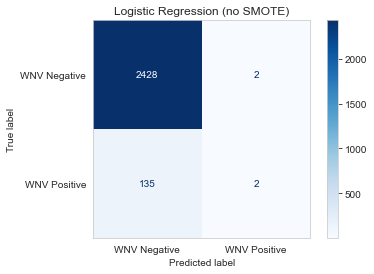

Accuracy: 0.947
Precision: 0.5
Recall: 0.015
F1: 0.029
ROC AUC: 0.8203


In [56]:
# Fitting LogReg to the our dataset

LogReg_Default = LogisticRegression(C=10, max_iter=10000, random_state=42)
run_model(LogReg_Default, 'Logistic Regression (no SMOTE)')

#### 2) Model Testing - Logistic Regression (with SMOTE)

Fitting 3 folds for each of 21 candidates, totalling 63 fits
Best Score: 0.9515341938997138
Best Parameters: {'lr__C': 1000, 'lr__class_weight': 'balanced', 'lr__solver': 'lbfgs'}
Score on Training Data: 0.958
Score on Testing Data: 0.932
Generalisation Score: 2.714


C:\Users\rohaz\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


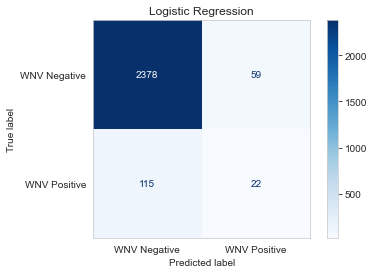

Accuracy: 0.932
Precision: 0.272
Recall: 0.161
F1: 0.202
ROC AUC: 0.8137


In [52]:
run_model_gs(pipe_lr, params_lr, model_name = 'Logistic Regression', prefix= 'lr')

#### 3) Model Testing - Random Forest Regression (with SMOTE)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits
Best Score: 0.9078129696828737
Best Parameters: {'rf__bootstrap': False, 'rf__max_depth': 50, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 3, 'rf__n_estimators': 150}
Score on Training Data: 0.955
Score on Testing Data: 0.869
Generalisation Score: 9.005


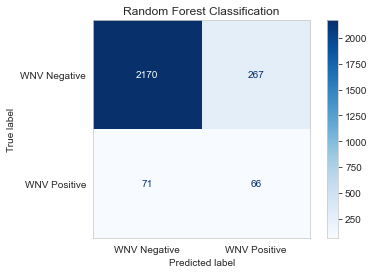

Accuracy: 0.869
Precision: 0.198
Recall: 0.482
F1: 0.281
ROC AUC: 0.8346


In [53]:
run_model_gs(pipe_rf, params_rf, model_name = 'Random Forest Classification', prefix = 'rf')

 #### 4) Model Testing - Decision Tree Classifier (with SMOTE)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Score: 0.9122125497290797
Best Parameters: {'dt__criterion': 'gini', 'dt__max_depth': 100, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 3}
Score on Training Data: 0.989
Score on Testing Data: 0.888
Generalisation Score: 10.212


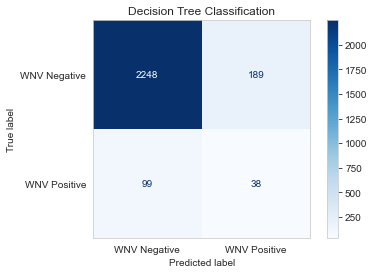

Accuracy: 0.888
Precision: 0.167
Recall: 0.277
F1: 0.208
ROC AUC: 0.6271


In [54]:
run_model_gs(pipe_dt, params_dt, model_name = 'Decision Tree Classification', prefix='dt')

#### 5) Model Testing - Multinomial Naive Bayes (with SMOTE)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Score: 0.8282015499665398
Best Parameters: {'mnb__alpha': 0.8}
Score on Training Data: 0.838
Score on Testing Data: 0.789
Generalisation Score: 5.847


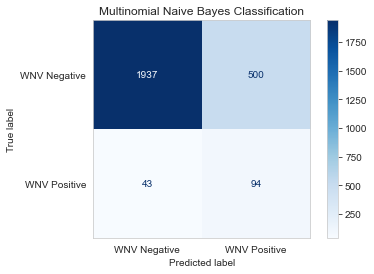

Accuracy: 0.789
Precision: 0.158
Recall: 0.686
F1: 0.257
ROC AUC: 0.8212


In [55]:
run_model_gs(pipe_mnb, params_mnb, model_name = 'Multinomial Naive Bayes Classification', prefix='mnb')

#### 6) Model Testing - K Nearest Neighbours (with SMOTE)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Score: 0.7883536636743914
Best Parameters: {'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
Score on Training Data: 0.9
Score on Testing Data: 0.637
Generalisation Score: 29.222


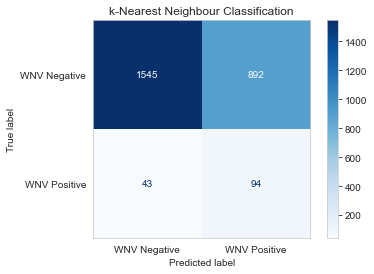

Accuracy: 0.637
Precision: 0.095
Recall: 0.686
F1: 0.167
ROC AUC: 0.6857


In [56]:
run_model_gs(pipe_knn, params_knn, model_name = 'k-Nearest Neighbour Classification',prefix='knn')

#### 7) Model Testing - AdaBoost (with SMOTE)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Score: 0.9508300076158988
Best Parameters: {'ada__learning_rate': 1, 'ada__n_estimators': 700}
Score on Training Data: 0.96
Score on Testing Data: 0.92
Generalisation Score: 4.167


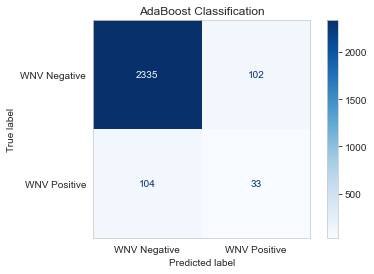

Accuracy: 0.92
Precision: 0.244
Recall: 0.241
F1: 0.242
ROC AUC: 0.8328


In [57]:
run_model_gs(pipe_ada, params_ada, model_name = 'AdaBoost Classification',prefix='ada')

In [58]:
gs_ada = pickle.load(open('./models/gs_ada.sav', 'rb'))

In [59]:
imp_ada = pd.DataFrame(gs_ada.named_steps['ada'].feature_importances_,
                      index=X_train.columns,
                      columns=['weights']).sort_values(by='weights', ascending=False)
imp_ada

,weights
Latitude,0.061429
Longitude,0.040000
Tmin_7d,0.022857
R_Humid,0.021429
DewPoint,0.020000
...,...
Month_8,0.000000
Trap_T097,0.000000
Trap_T215,0.000000
Trap_T016,0.000000


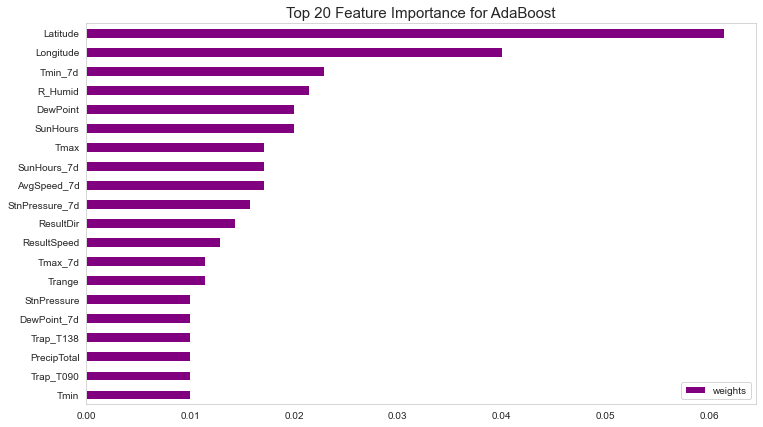

In [60]:
# Plotting Top 20 features in bar chart
imp_ada.head(20).plot(kind='barh', label=imp_ada.columns[:20], figsize=(12,7), color='purple')
plt.title('Top 20 Feature Importance for AdaBoost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

#### 8) Model Testing - XGBoost (with SMOTE)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Score: 0.9355225850509727
Best Parameters: {'xgb__gamma': 0.1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 150}
Score on Training Data: 0.971
Score on Testing Data: 0.886
Generalisation Score: 8.754


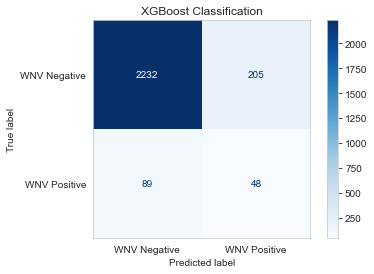

Accuracy: 0.886
Precision: 0.19
Recall: 0.35
F1: 0.246
ROC AUC: 0.8437


In [61]:
run_model_gs(pipe_xgb, params_xgb, model_name = 'XGBoost Classification', prefix='xgb')

#### 9) Gradient Boosting Classification (with SMOTE)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
Best Score: 0.9529405470123323
Best Parameters: {'gb__learning_rate': 1, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 7, 'gb__n_estimators': 250}
Score on Training Data: 0.979
Score on Testing Data: 0.913
Generalisation Score: 6.742


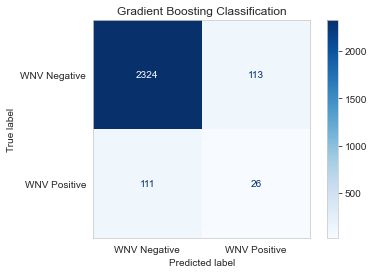

Accuracy: 0.913
Precision: 0.187
Recall: 0.19
F1: 0.188
ROC AUC: 0.8224


In [62]:
run_model_gs(pipe_gb, params_gb, model_name = 'Gradient Boosting Classification',prefix='gb')

### Visualising ROC Curve for the models

In [57]:
# Load the pickled model
gs_lr = pickle.load(open('./models/gs_lr.sav', 'rb'))
gs_rf = pickle.load(open('./models/gs_rf.sav', 'rb'))
gs_dt = pickle.load(open('./models/gs_dt.sav', 'rb'))
gs_mnb = pickle.load(open('./models/gs_mnb.sav', 'rb'))
gs_knn = pickle.load(open('./models/gs_knn.sav', 'rb'))
gs_ada= pickle.load(open('./models/gs_ada.sav', 'rb'))
gs_xgb = pickle.load(open('./models/gs_xgb.sav', 'rb'))
gs_gb = pickle.load(open('./models/gs_gb.sav', 'rb'))

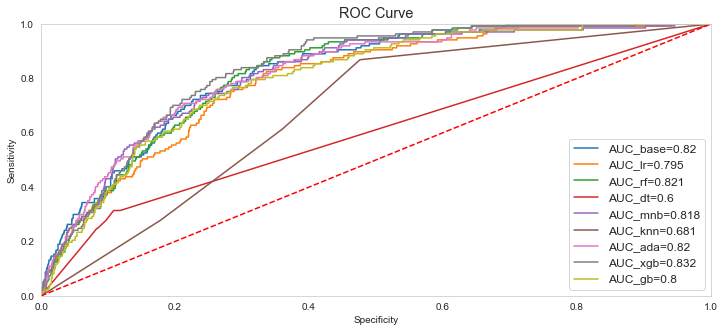

In [58]:
from sklearn import metrics

y_pred_base = LogReg_Default.predict_proba(X_test)[::,1]
y_pred_lr = gs_lr.predict_proba(X_test)[::,1]
y_pred_rf = gs_rf.predict_proba(X_test)[::,1]
y_pred_dt = gs_dt.predict_proba(X_test)[::,1]
y_pred_mnb = gs_mnb.predict_proba(X_test)[::,1]
y_pred_knn = gs_knn.predict_proba(X_test)[::,1]
y_pred_ada = gs_ada.predict_proba(X_test)[::,1]
y_pred_xgb = gs_xgb.predict_proba(X_test)[::,1]
y_pred_gb = gs_gb.predict_proba(X_test)[::,1]


base_fpr, base_tpr, _ = metrics.roc_curve(y_test,  y_pred_base)
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test,  y_pred_lr)
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test,  y_pred_rf)
dt_fpr, dt_tpr, _ = metrics.roc_curve(y_test,  y_pred_dt)
mnb_fpr, mnb_tpr, _ = metrics.roc_curve(y_test,  y_pred_mnb)
knn_fpr, knn_tpr, _ = metrics.roc_curve(y_test,  y_pred_knn)
ada_fpr, ada_tpr, _ = metrics.roc_curve(y_test,  y_pred_ada)
xgb_fpr, xgb_tpr, _ = metrics.roc_curve(y_test,  y_pred_xgb)
gb_fpr, gb_tpr, _ = metrics.roc_curve(y_test,  y_pred_gb)


auc1 = metrics.roc_auc_score(y_test, y_pred_base)
auc2 = metrics.roc_auc_score(y_test, y_pred_lr)
auc3 = metrics.roc_auc_score(y_test, y_pred_rf)
auc4 = metrics.roc_auc_score(y_test, y_pred_dt)
auc5 = metrics.roc_auc_score(y_test, y_pred_mnb)
auc6 = metrics.roc_auc_score(y_test, y_pred_knn)
auc7 = metrics.roc_auc_score(y_test, y_pred_ada)
auc8 = metrics.roc_auc_score(y_test, y_pred_xgb)
auc9 = metrics.roc_auc_score(y_test, y_pred_gb)


plt.figure(figsize=(12,5))
#create ROC curve
plt.plot(base_fpr, base_tpr,label="AUC_base="+str(round(auc1,3)))
plt.plot(lr_fpr, lr_tpr,label="AUC_lr="+str(round(auc2,3)))
plt.plot(rf_fpr,rf_tpr,label="AUC_rf="+str(round(auc3,3)))
plt.plot(dt_fpr,dt_tpr,label="AUC_dt="+str(round(auc4,3)))
plt.plot(mnb_fpr,mnb_tpr,label="AUC_mnb="+str(round(auc5,3)))
plt.plot(knn_fpr,knn_tpr,label="AUC_knn="+str(round(auc6,3)))
plt.plot(ada_fpr,ada_tpr,label="AUC_ada="+str(round(auc7,3)))
plt.plot(xgb_fpr,xgb_tpr,label="AUC_xgb="+str(round(auc8,3)))
plt.plot(gb_fpr,gb_tpr,label="AUC_gb="+str(round(auc9,3)))

# Set limit
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12

# Plot random
plt.plot([0, 1], [0, 1],'r--')

# axis labels
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')

# show title
plt.title("ROC Curve")

plt.legend(loc=4)
plt.show()

# plt.savefig("./images/roc_curve.png", format="png")

As AdaBoost give us the best score, SMOTE + AdaBoost will be used as the production model for submission to Kaggle

### Model evaluation and recommendations¶

In [82]:
results_df = pd.DataFrame(results, index=['Train score', 'Test score', 'Generalisation','Accuracy', 'Precision', 'Recall', 'Specificity','F1', 'ROC AUC']).T
results_df                            
#print(results_df.to_markdown(index=False))

,Train score,Test score,Generalisation,Accuracy,Precision,Recall,Specificity,F1,ROC AUC
Logistic Regression (no SMOTE),0.946,0.947,-0.106,0.947,0.500,0.022,0.999,0.042,0.8342
Logistic Regression,0.958,0.932,2.714,0.932,0.272,0.161,0.976,0.202,0.8137
Random Forest Classification,0.955,0.869,9.005,0.869,0.198,0.482,0.890,0.281,0.8346
Decision Tree Classification,0.989,0.888,10.212,0.888,0.167,0.277,0.922,0.208,0.6271
Multinomial Naive Bayes Classification,0.838,0.789,5.847,0.789,0.158,0.686,0.795,0.257,0.8212
k-Nearest Neighbour Classification,0.900,0.637,29.222,0.637,0.095,0.686,0.634,0.167,0.6857
AdaBoost Classification,0.960,0.920,4.167,0.920,0.244,0.241,0.958,0.242,0.8328
XGBoost Classification,0.971,0.886,8.754,0.886,0.190,0.350,0.916,0.246,0.8437
Gradient Boosting Classification,0.979,0.913,6.742,0.913,0.187,0.190,0.954,0.188,0.8224


In choosing the best model, we looked at several criterias:
1. ROC AUC score > 0.8 
2. Generalisation < 5% 
3. F1 score 

<br>Based on the above criterias, we have selected AdaBoost+SMOTE. 
- **ROC AUC** of 0.8328 infers that the model has a good capability of classifying the positive class in the dataset.
- **Generalisation Score** of 4.167% means that the model has the ability to properly adapt to new, previously unseen data, drawn from the same distribution as the one used to create the model.
- **Recall** of 0.241. The high recall score means our modell succeeds well in finding all the positive cases in the data, even though it may also wrongly identify some negative cases as positive cases.
- **F1 score** of 0.242. As F1 Score is an average of Precision and Recall, it means that the F1 score gives equal weight to Precision and Recall. All the models does not have a great F1 Score. However, our model has a good balance of both Precision and Recall. 

### Kaggle Submission

In [59]:
# Set up dataframe to save as csv for submission
y_kag_test_id = pd.DataFrame(test_weather["Id"], columns=["Id"])

In [60]:
y_kag_test_id.head()

,Id
0,1
1,2
2,3
3,4
4,5


In [63]:
X_kag_test.describe()

,Latitude,Longitude,Tmax,Tmin,DewPoint,Heat,WetDry,PrecipTotal,StnPressure,ResultSpeed,ResultDir,AvgSpeed,SunHours,R_Humid,Trange,Tmax_7d,Tmin_7d,DewPoint_7d,Heat_7d,WetDry_7d,PrecipTotal_7d,StnPressure_7d,ResultSpeed_7d,ResultDir_7d,AvgSpeed_7d,SunHours_7d,Trange_7d,R_Humid_7d,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_OTHERS,Trap_T002,Trap_T003,Trap_T004,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T009,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T018,Trap_T019,Trap_T025,Trap_T027,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T040,Trap_T043,Trap_T044,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T054C,Trap_T060,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T072,Trap_T073,Trap_T074,Trap_T075,Trap_T076,Trap_T077,Trap_T078,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T083,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T089,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T094B,Trap_T095,Trap_T096,Trap_T097,Trap_T099,Trap_T100,Trap_T102,Trap_T103,Trap_T107,Trap_T114,Trap_T115,Trap_T128,Trap_T129,Trap_T135,Trap_T138,Trap_T141,Trap_T142,Trap_T143,Trap_T144,Trap_T145,Trap_T146,Trap_T147,Trap_T148,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T157,Trap_T158,Trap_T159,Trap_T160,Trap_T161,Trap_T162,Trap_T200,Trap_T206,Trap_T209,Trap_T212,Trap_T215,Trap_T218,Trap_T219,Trap_T220,Trap_T221,Trap_T222,Trap_T223,Trap_T224,Trap_T225,Trap_T226,Trap_T227,Trap_T228,Trap_T229,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903,Month_7,Month_8,Month_9,Month_10,Week_23,Week_24,Week_25,Week_26,Week_27,Week_28,Week_29,Week_30,Week_31,Week_32,Week_33,Week_34,Week_35,Week_36,Week_37,Week_38,Week_39,Week_40
count,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.00000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.00000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,116293.000000,11629

In [64]:
numerical_features = X_kag_test.select_dtypes(include = ['float64', 'int64']).columns

In [65]:
scaler = pd.read_pickle('scaler.sav')
X_kag_test[numerical_features] = scaler.transform(X_kag_test[numerical_features])

c:\Users\Mingzi\Anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [67]:
# Instantiate the model with best params
ada_kaggle = gs_ada

In [68]:
# Predict result using fitted AdaBoost model
y_kag_pred= ada_kaggle.predict_proba(X_kag_test)[:,1]

In [69]:
# Merge ID with y_kag_pred for Kaggle submission
y_kag_test_id["WnvPresent"] = y_kag_pred

In [70]:
# Save csv for submission
y_kag_test_id.to_csv('./data/kaggle_submission_proba.csv', index = False)